In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import copy
from scipy import stats
from scipy.stats import ks_2samp
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_goldfeldquandt
from scipy.stats import f_oneway

In [ ]:
hour_data = pd.read_csv('~/hour.csv')

In [ ]:
hour_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Описание датасета
Датасет содержит информацию о почасовом количестве арендованных велосипедов в период с 2011 по 2012 год в системе Capital bikeshare в Вашингтоне, округ Колумбия, с соответствующей информацией о погоде и сезонах.
- instant: индекс записи
- dteday : дата
- season : сезон (1:springer, 2:summer, 3:fall, 4:winter)
- yr : год (0: 2011, 1:2012)
- mnth : месяц (1 to 12)
- hr : час (0 to 23)
- holiday : выходной день или нет
- weekday : день недели
- workingday : если день не является ни выходным, ни праздничным, равно 1, в противном случае равно 0
+ weathersit : прогноз погоды
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : нормализованная температура в градусах Цельсия. Значения разделены на 41 (макс.)
- atemp: Нормализованная температура на ощупь в градусах Цельсия. Значения разделены на 50 (макс.)
- hum: Нормализованная влажность. Значения разделены на 100 (макс.)
- windspeed: Нормализованная скорость ветра. Значения делятся на 67 (максимум)
- casual: количество случайных пользователей
- registered: количество зарегистрированных пользователей
- cnt: общее количество арендованных велосипедов, включая как обычных, так и зарегистрированных пользователей

# Постановка задачи
Необходимо:
- провести анализ датасета на предмет распределений признаков между сезонами;
- сформулировать и протестировать несколько важных продуктовых гипотез;
- основываясь на предоставленной информации о погоде и сезонах, предсказать общее количество арендованных велосипедов (общее количество пользователей).

# EDA

In [ ]:
hour_data.drop('instant', axis=1, inplace=True)

In [ ]:
hour_data.dtypes

dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [ ]:
hour_data['dteday'] = pd.to_datetime(hour_data['dteday'])

In [ ]:
hour_data.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [ ]:
hour_data.duplicated().sum()

0

In [ ]:
df = copy.deepcopy(hour_data)

In [ ]:
df = copy.deepcopy(hour_data)
df.drop('dteday', axis=1, inplace=True)

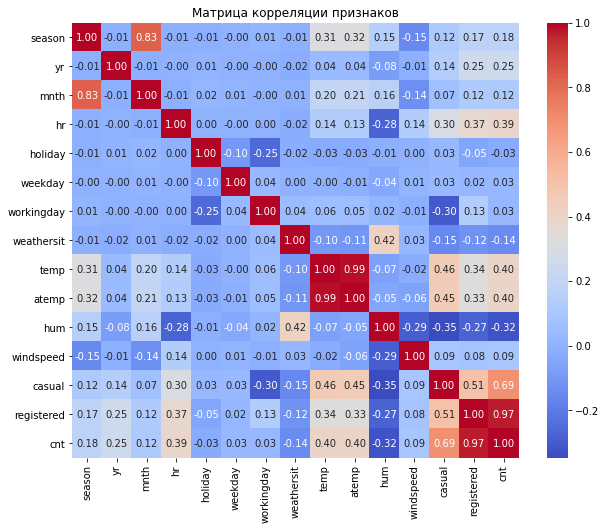

In [ ]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Матрица корреляции признаков')
plt.show()

Признаки 'temp' и 'atemp' имеют очень высокую корреляцию.  Также высокую корреляцию имеют признаки 'mnth' и 'season'. Важно учитывать это для дальнейшего анализа и при обучении модели линейной регрессии методом МНК.

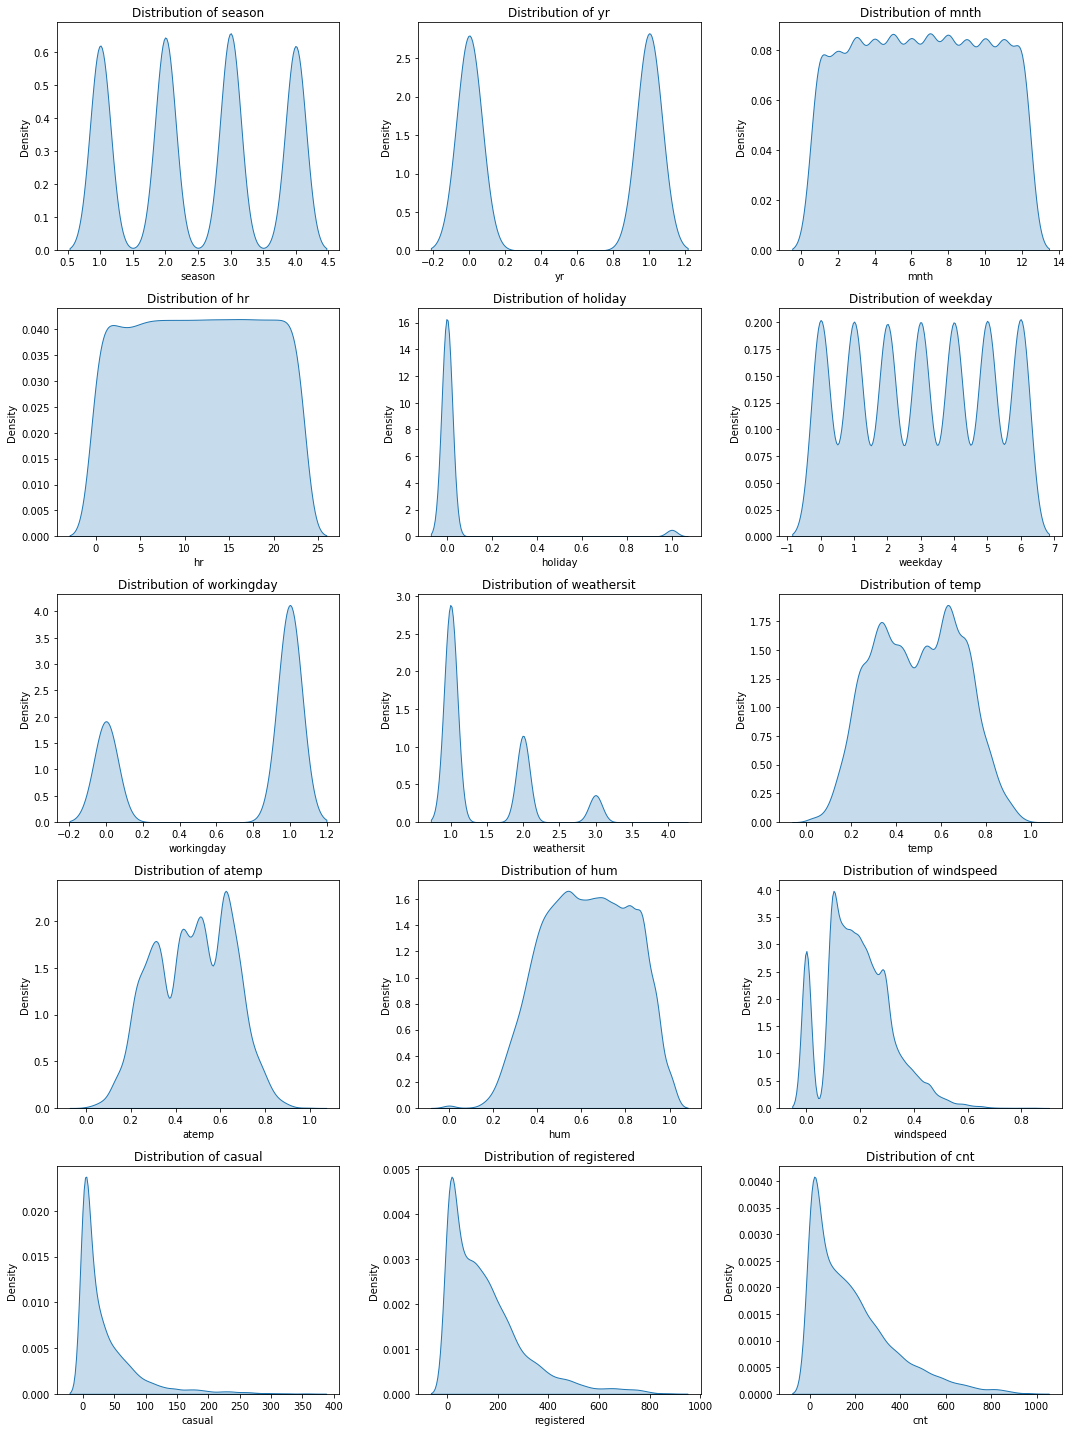

In [ ]:
num_cols = 3
num_rows = (len(df.columns) - 1) // num_cols + 1

plt.figure(figsize=(15, 20))

for i, column in enumerate(df.columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.kdeplot(data=df[column], shade=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()

plt.show()

Распределения нигде не имеют форму нормального распределения, это нужно учитывать при дальнейшем анализе и статистической проверке гипотез.

# Анализ датасета на предмет распределений пользователей между различными сезонами.

Проведем сегментацию по сезонам и посмотрим насколько отличаются признаки между сегмантами.

In [ ]:
spring_data = hour_data[hour_data['season'] == 1]
summer_data = hour_data[hour_data['season'] == 2]
fall_data = hour_data[hour_data['season'] == 3]
winter_data = hour_data[hour_data['season'] == 4]

Сравним распределения по сезонам категориальных и непрерывных признаков.

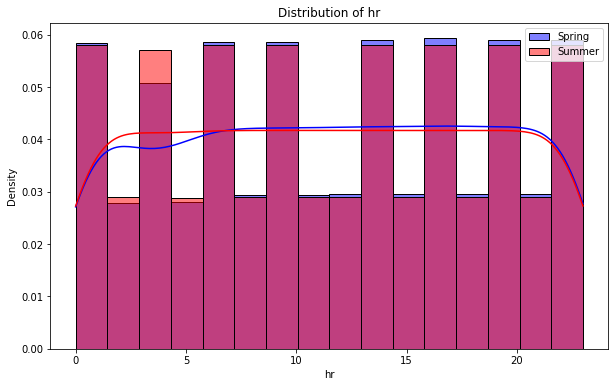

Feature: hr, Seasons: Spring vs Summer
KS Statistic: 0.011421229282310015, KS p-value: 0.9361979383512847
PSI: 0.001419867628549097
----------------------------------------------


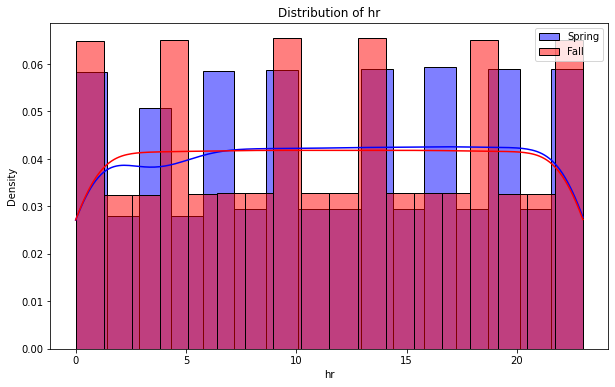

Feature: hr, Seasons: Spring vs Fall
KS Statistic: 0.011499875839134498, KS p-value: 0.9305287983608348
PSI: 0.0016332372446088382
----------------------------------------------


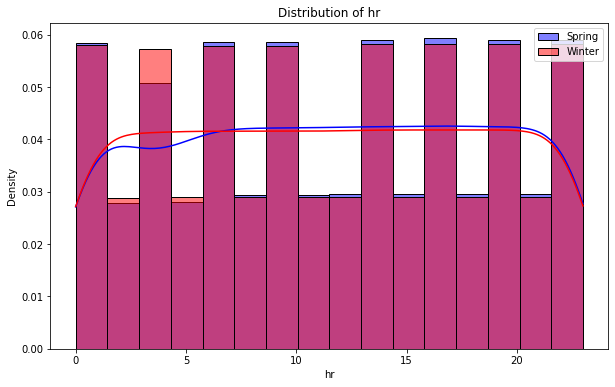

Feature: hr, Seasons: Spring vs Winter
KS Statistic: 0.011430501003111384, KS p-value: 0.9402845021360279
PSI: 0.001496830247967408
----------------------------------------------


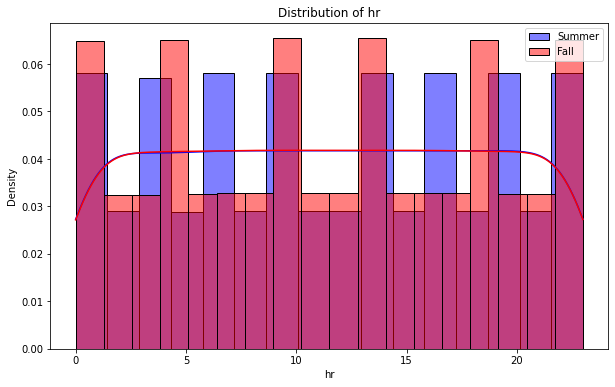

Feature: hr, Seasons: Summer vs Fall
KS Statistic: 0.0008657174866356345, KS p-value: 1.0
PSI: 2.6716453221911447e-05
----------------------------------------------


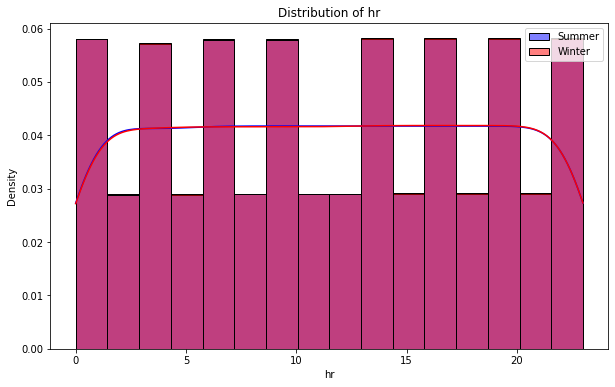

Feature: hr, Seasons: Summer vs Winter
KS Statistic: 0.0010051510036396595, KS p-value: 1.0
PSI: 2.8311245491376228e-05
----------------------------------------------


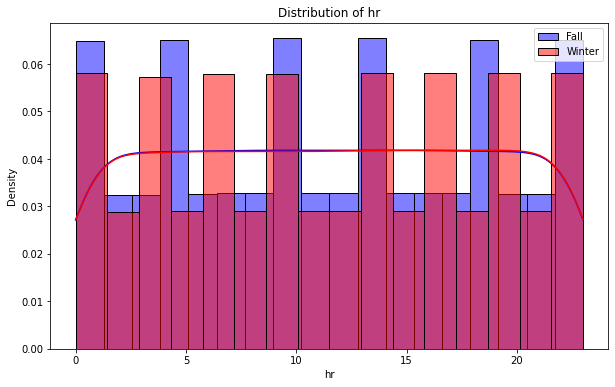

Feature: hr, Seasons: Fall vs Winter
KS Statistic: 0.0014362693324543052, KS p-value: 1.0
PSI: 2.3520165186137726e-05
----------------------------------------------


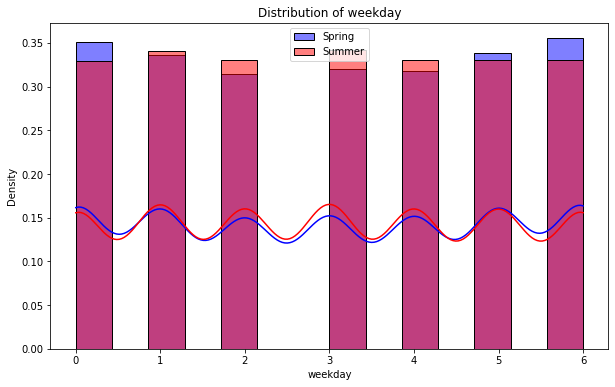

Feature: weekday, Seasons: Spring vs Summer
KS Statistic: 0.01420805820335136, KS p-value: 0.7675173559399328
PSI: 0.002609864226118075
----------------------------------------------


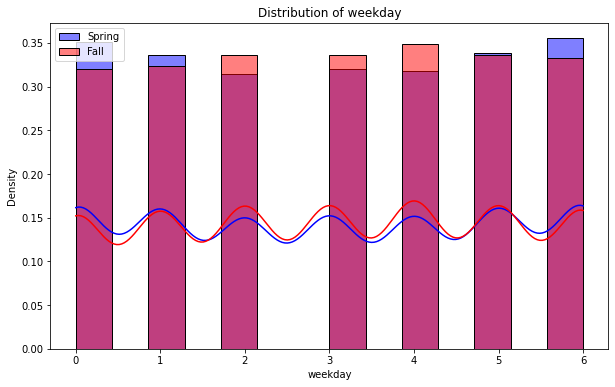

Feature: weekday, Seasons: Spring vs Fall
KS Statistic: 0.01887161263152243, KS p-value: 0.4116131234242768
PSI: 0.0041968531942027905
----------------------------------------------


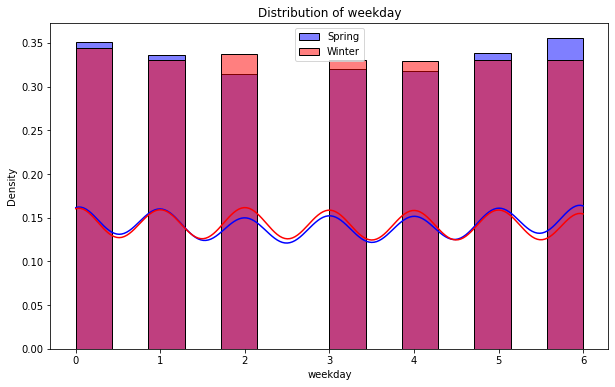

Feature: weekday, Seasons: Spring vs Winter
KS Statistic: 0.013711565593502369, KS p-value: 0.812768495688327
PSI: 0.0019304227223698074
----------------------------------------------


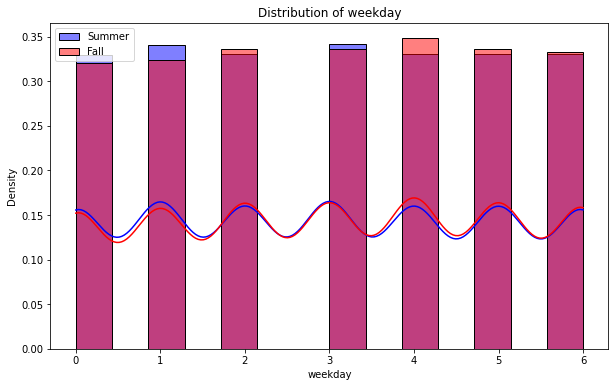

Feature: weekday, Seasons: Summer vs Fall
KS Statistic: 0.011579406487377404, KS p-value: 0.9215262911110784
PSI: 0.00105798505110768
----------------------------------------------


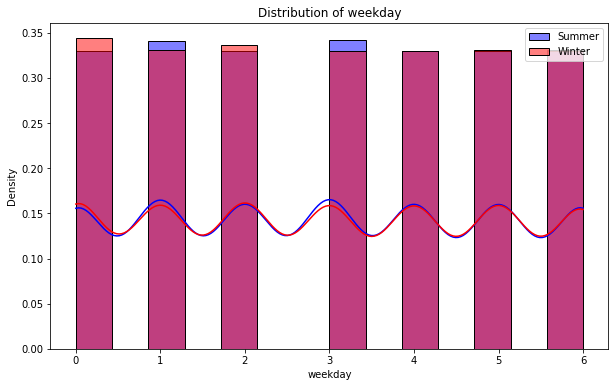

Feature: weekday, Seasons: Summer vs Winter
KS Statistic: 0.00614613260983184, KS p-value: 0.999996140553328
PSI: 0.0006143964498360825
----------------------------------------------


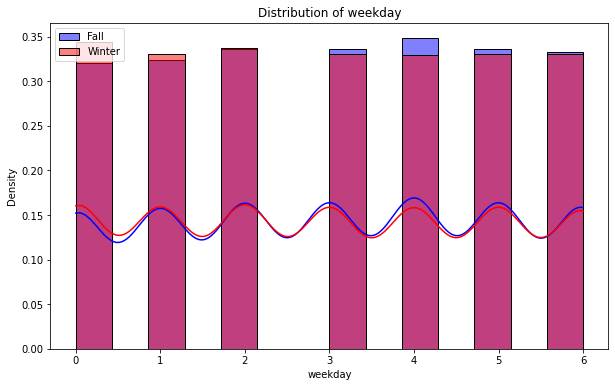

Feature: weekday, Seasons: Fall vs Winter
KS Statistic: 0.013894728521550766, KS p-value: 0.78643570228042
PSI: 0.0013324870363306703
----------------------------------------------


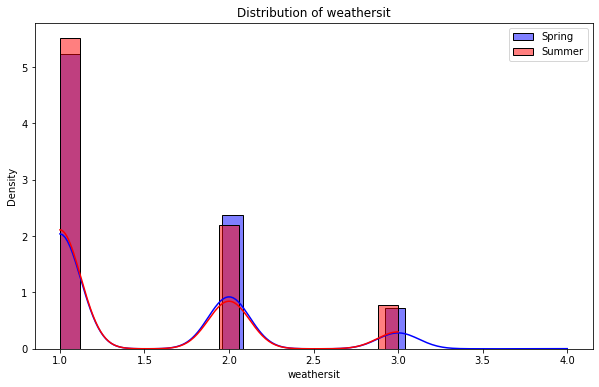

Feature: weathersit, Seasons: Spring vs Summer
KS Statistic: 0.020204964150628845, KS p-value: 0.3343824203578001
PSI: 0.0041486702824982446
----------------------------------------------


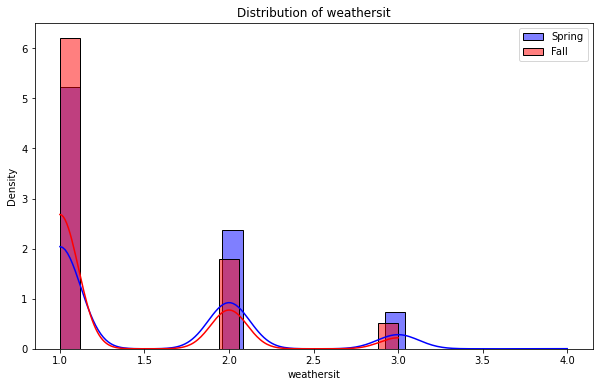

Feature: weathersit, Seasons: Spring vs Fall
KS Statistic: 0.10129597097991447, KS p-value: 2.3314683517128287e-15
PSI: 0.08395160083879603
----------------------------------------------


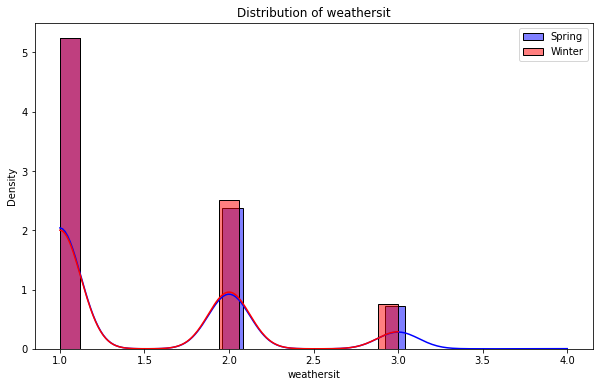

Feature: weathersit, Seasons: Spring vs Winter
KS Statistic: 0.011748011825217088, KS p-value: 0.9267766494546613
PSI: 0.0006995569950221628
----------------------------------------------


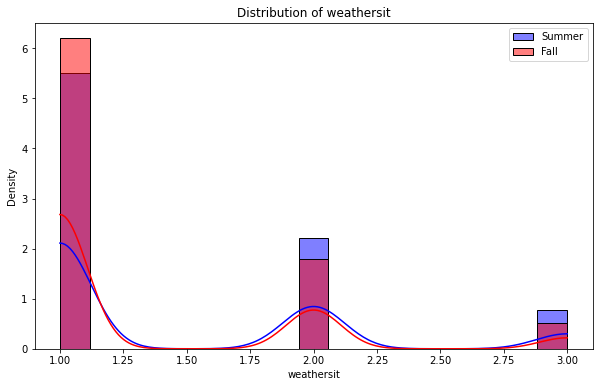

Feature: weathersit, Seasons: Summer vs Fall
KS Statistic: 0.08109100682928562, KS p-value: 3.4872105203476167e-13
PSI: 0.08109524991413912
----------------------------------------------


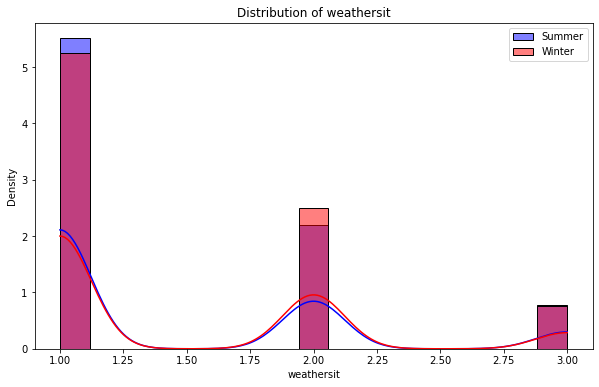

Feature: weathersit, Seasons: Summer vs Winter
KS Statistic: 0.03195297597584593, KS p-value: 0.023610895879961902
PSI: 0.006804070437315332
----------------------------------------------


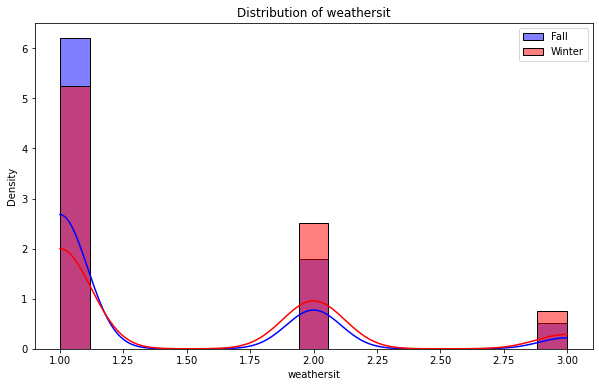

Feature: weathersit, Seasons: Fall vs Winter
KS Statistic: 0.11304398280513155, KS p-value: 1.0097973591435363e-24
PSI: 0.09860722430982105
----------------------------------------------


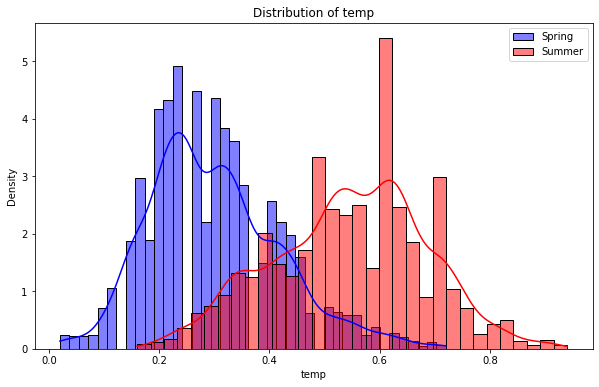

Feature: temp, Seasons: Spring vs Summer
KS Statistic: 0.6417155064824436, KS p-value: 0.08535013830942251
PSI: 4.979661960433147
----------------------------------------------


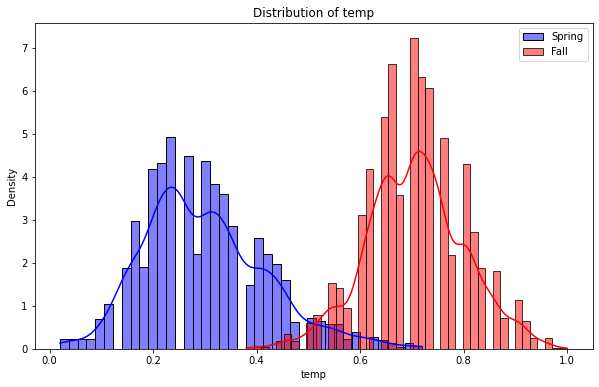

Feature: temp, Seasons: Spring vs Fall
KS Statistic: 0.9234450739176612, KS p-value: 0.33015195952118204
PSI: 8.233732903915902
----------------------------------------------


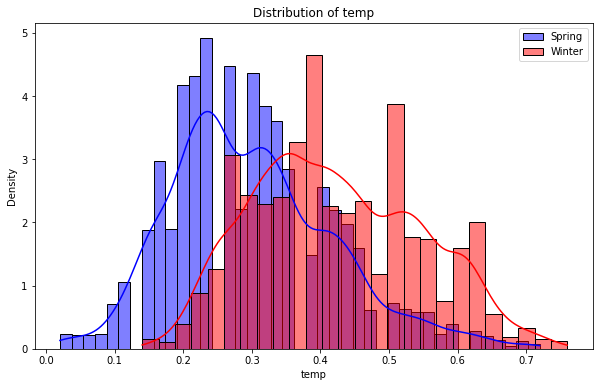

Feature: temp, Seasons: Spring vs Winter
KS Statistic: 0.3953093290695529, KS p-value: 1.3322676295501878e-15
PSI: 2.336611975620429
----------------------------------------------


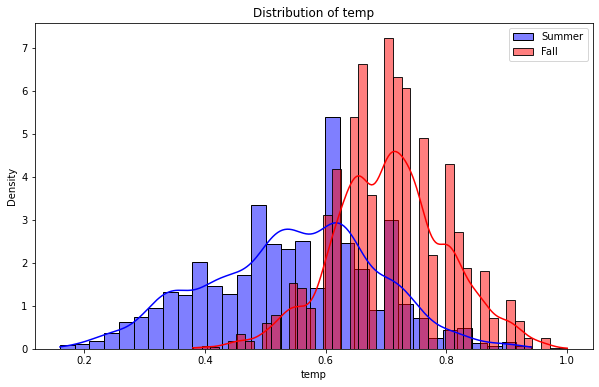

Feature: temp, Seasons: Summer vs Fall
KS Statistic: 0.5252473608253581, KS p-value: 0.0013988330945391425
PSI: 3.7188870901094204
----------------------------------------------


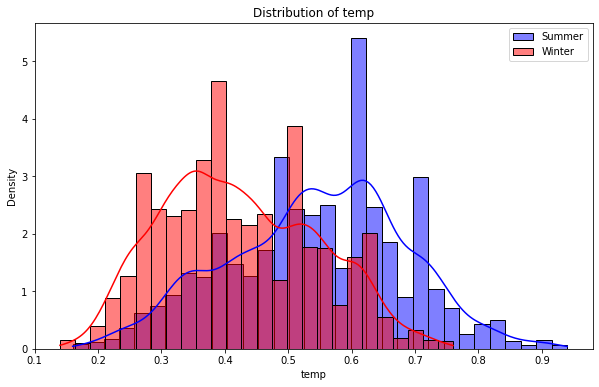

Feature: temp, Seasons: Summer vs Winter
KS Statistic: 0.3682903289842353, KS p-value: 3.786484255878964e-263
PSI: 1.703055908127728
----------------------------------------------


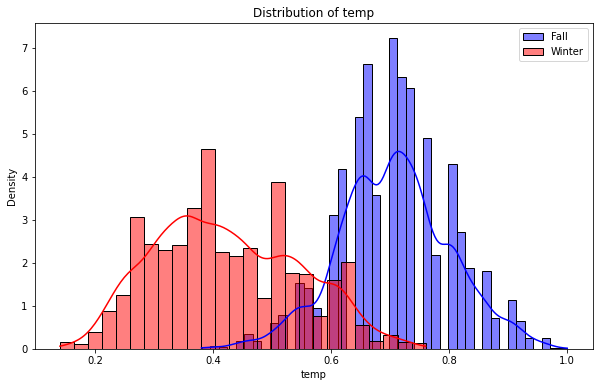

Feature: temp, Seasons: Fall vs Winter
KS Statistic: 0.7940105550659607, KS p-value: 0.33108996717989125
PSI: 7.663684429870409
----------------------------------------------


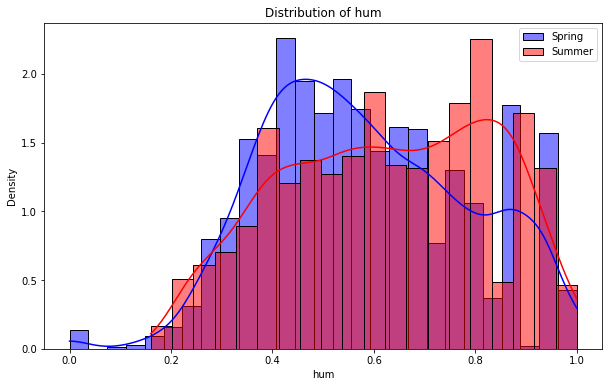

Feature: hum, Seasons: Spring vs Summer
KS Statistic: 0.13416975628159322, KS p-value: 1.887379141862766e-15
PSI: 1.332614982626562
----------------------------------------------


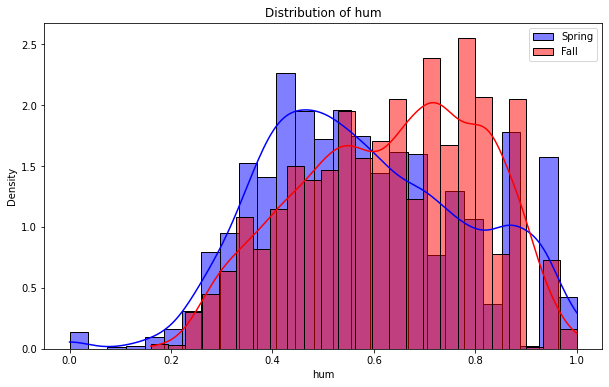

Feature: hum, Seasons: Spring vs Fall
KS Statistic: 0.162672650717029, KS p-value: 2.3314683517128287e-15
PSI: 2.2249039915029334
----------------------------------------------


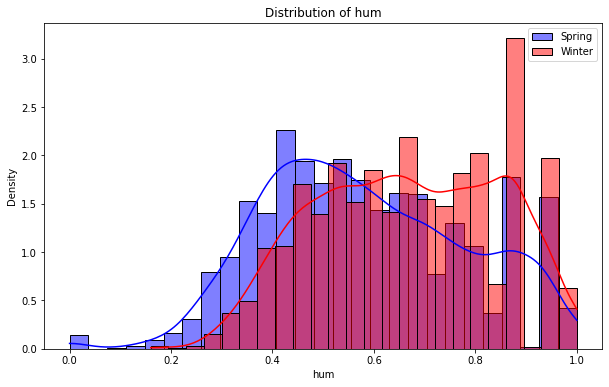

Feature: hum, Seasons: Spring vs Winter
KS Statistic: 0.2006517995844953, KS p-value: 1.3322676295501878e-15
PSI: 1.1698179692292787
----------------------------------------------


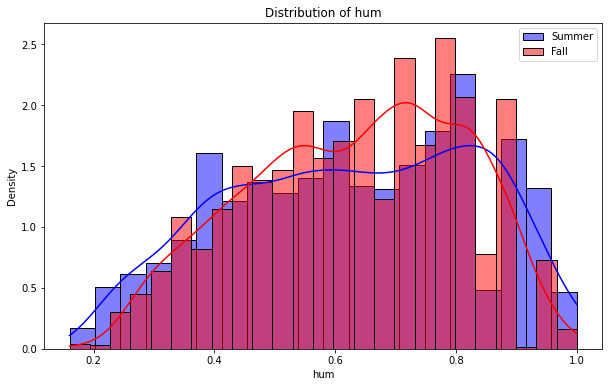

Feature: hum, Seasons: Summer vs Fall
KS Statistic: 0.06614432707604713, KS p-value: 6.447408829046708e-09
PSI: 1.352092953346721
----------------------------------------------


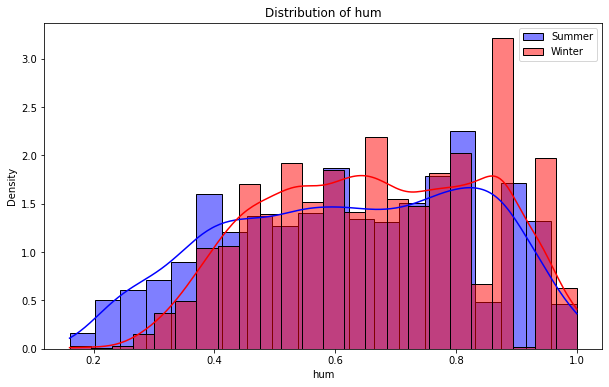

Feature: hum, Seasons: Summer vs Winter
KS Statistic: 0.10573095245547323, KS p-value: 1.803976041274806e-21
PSI: 0.9132595823233141
----------------------------------------------


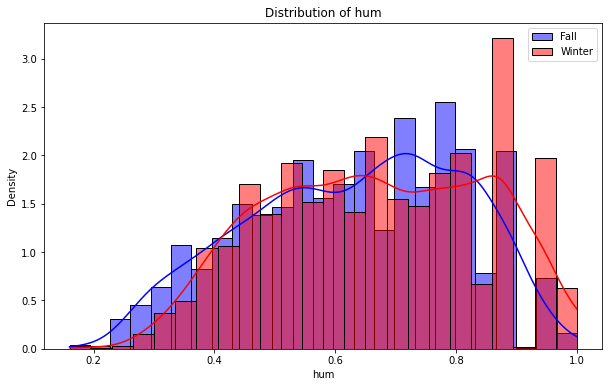

Feature: hum, Seasons: Fall vs Winter
KS Statistic: 0.10495950191390457, KS p-value: 2.2977628786468806e-21
PSI: 1.9325493265161138
----------------------------------------------


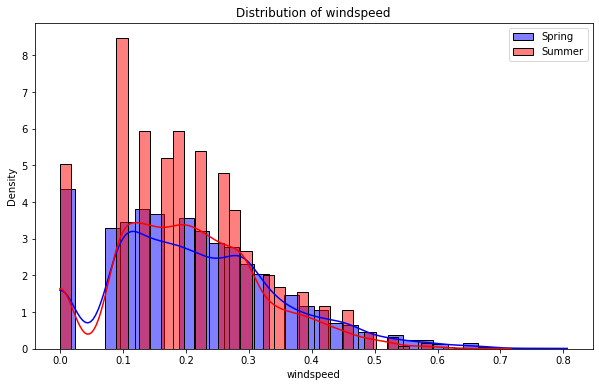

Feature: windspeed, Seasons: Spring vs Summer
KS Statistic: 0.0619486907379135, KS p-value: 1.1633916963127433e-07
PSI: 0.4152127844132856
----------------------------------------------


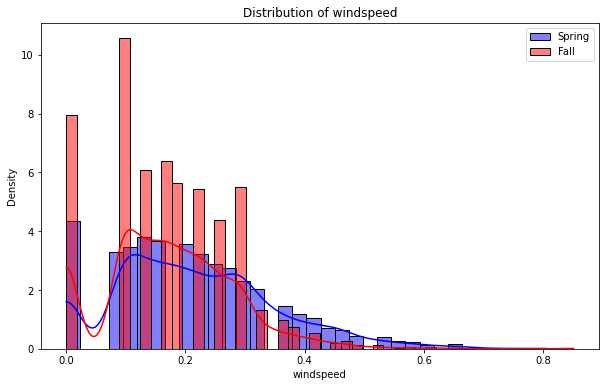

Feature: windspeed, Seasons: Spring vs Fall
KS Statistic: 0.15275100209563408, KS p-value: 2.3314683517128287e-15
PSI: 0.9755400798351271
----------------------------------------------


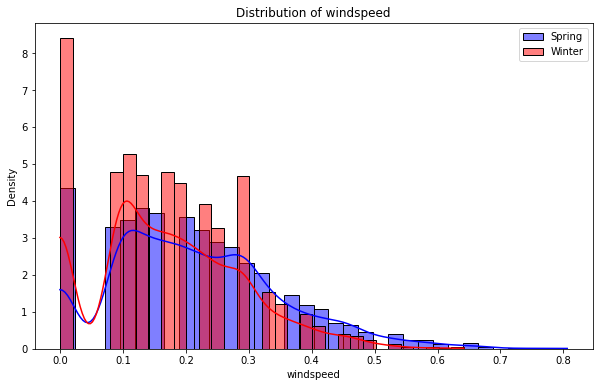

Feature: windspeed, Seasons: Spring vs Winter
KS Statistic: 0.12642155722458553, KS p-value: 1.3322676295501878e-15
PSI: 0.7237358625367288
----------------------------------------------


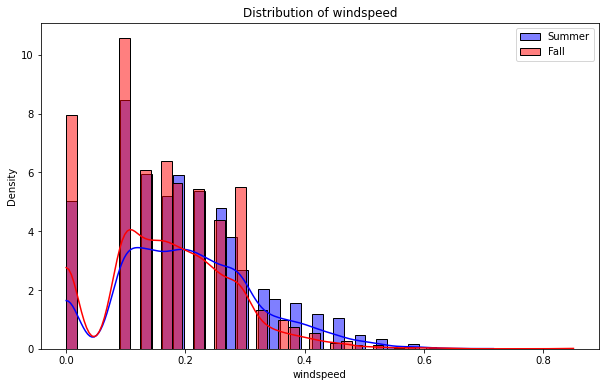

Feature: windspeed, Seasons: Summer vs Fall
KS Statistic: 0.10778049024601087, KS p-value: 5.663775640214549e-23
PSI: 0.38392628522895983
----------------------------------------------


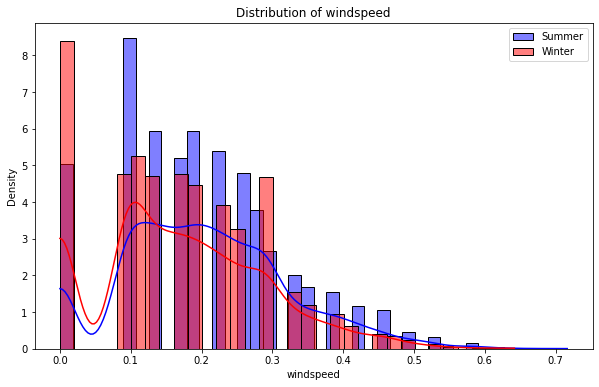

Feature: windspeed, Seasons: Summer vs Winter
KS Statistic: 0.1277870363978818, KS p-value: 3.4074483761606733e-31
PSI: 0.20612442380809534
----------------------------------------------


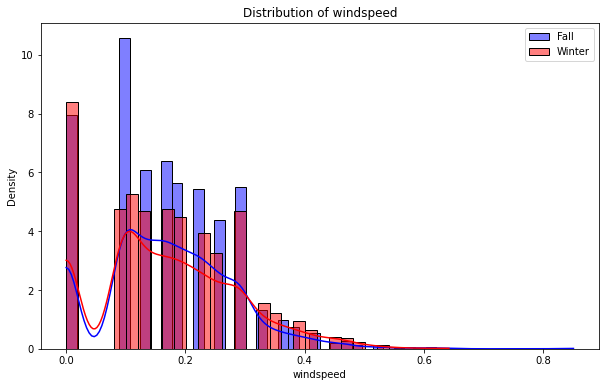

Feature: windspeed, Seasons: Fall vs Winter
KS Statistic: 0.04149582237351075, KS p-value: 0.0010557558341263151
PSI: 0.14619367539567094
----------------------------------------------


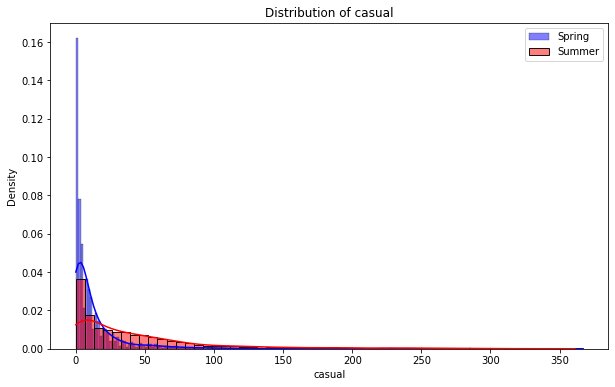

Feature: casual, Seasons: Spring vs Summer
KS Statistic: 0.38468777539063564, KS p-value: 1.887379141862766e-15
PSI: 1.4248791157110066
----------------------------------------------


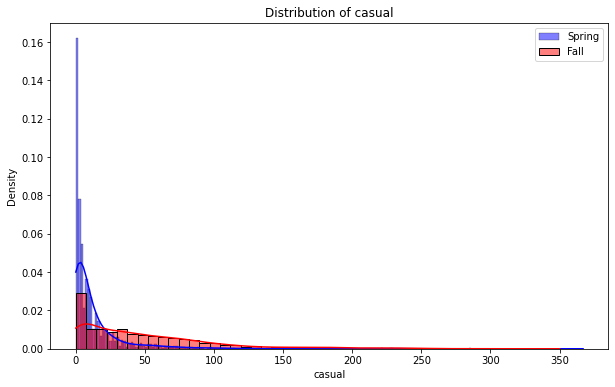

Feature: casual, Seasons: Spring vs Fall
KS Statistic: 0.4635156862152916, KS p-value: 1.0051407595135231e-08
PSI: 1.8900691920943133
----------------------------------------------


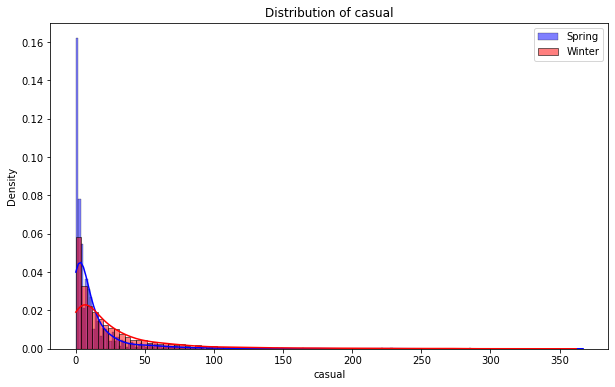

Feature: casual, Seasons: Spring vs Winter
KS Statistic: 0.24199349113955415, KS p-value: 1.3322676295501878e-15
PSI: 0.6602156685123471
----------------------------------------------


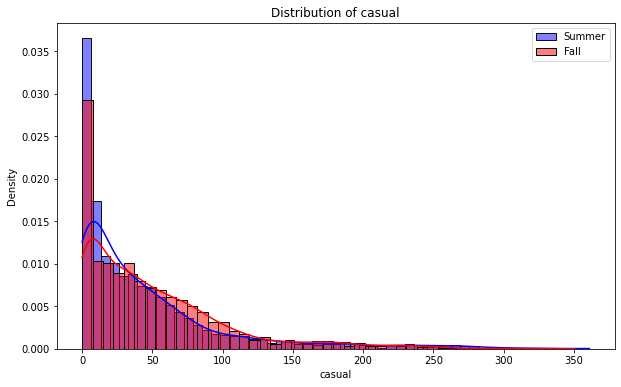

Feature: casual, Seasons: Summer vs Fall
KS Statistic: 0.09070273599213514, KS p-value: 2.1896867351793468e-16
PSI: 0.47186897398442046
----------------------------------------------


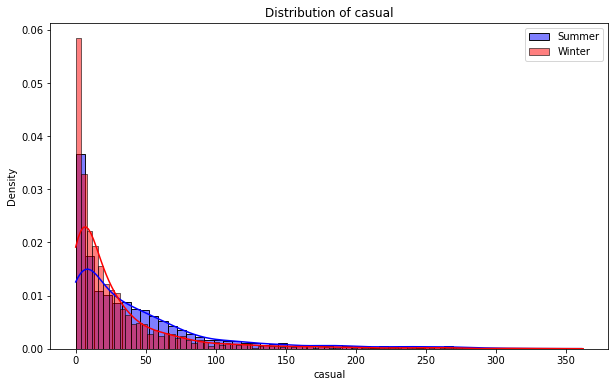

Feature: casual, Seasons: Summer vs Winter
KS Statistic: 0.17691799211185574, KS p-value: 1.3928062539671615e-59
PSI: 0.5678660790501964
----------------------------------------------


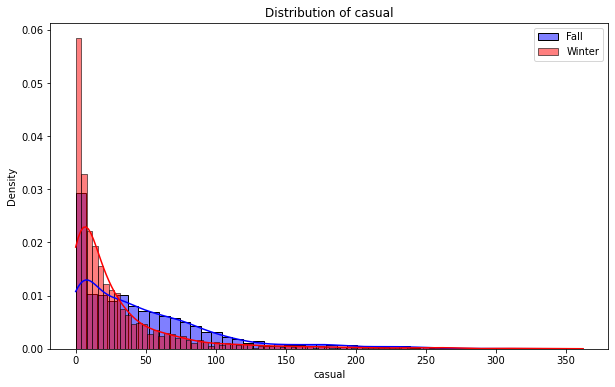

Feature: casual, Seasons: Fall vs Winter
KS Statistic: 0.26203422155547634, KS p-value: 1.459477858520317e-132
PSI: 0.7531056602644666
----------------------------------------------


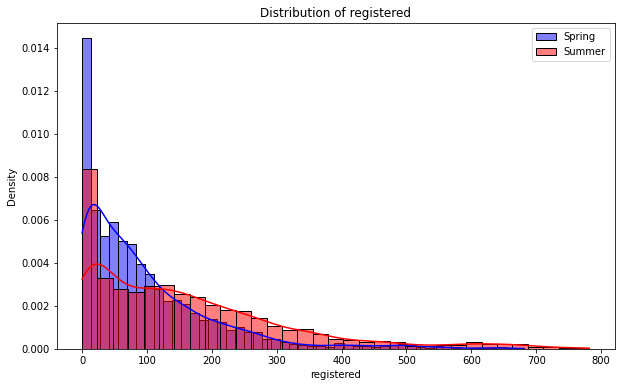

Feature: registered, Seasons: Spring vs Summer
KS Statistic: 0.23344747558383483, KS p-value: 1.887379141862766e-15
PSI: 0.6322837895283778
----------------------------------------------


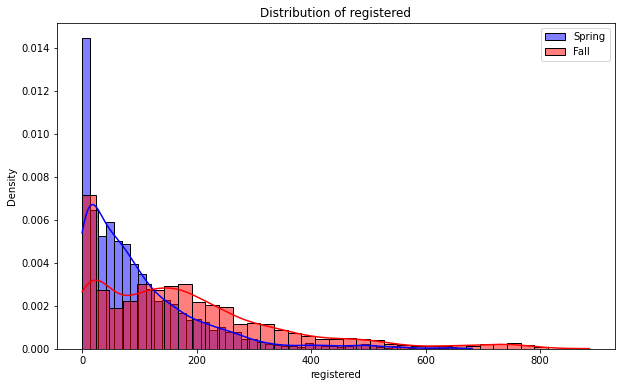

Feature: registered, Seasons: Spring vs Fall
KS Statistic: 0.3041154712827663, KS p-value: 2.3314683517128287e-15
PSI: 0.7872173194258575
----------------------------------------------


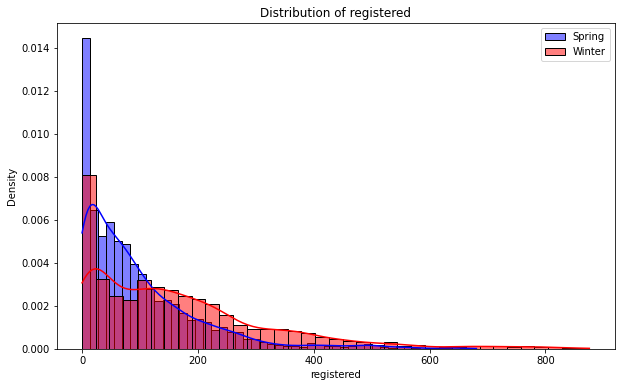

Feature: registered, Seasons: Spring vs Winter
KS Statistic: 0.252617848876435, KS p-value: 1.3322676295501878e-15
PSI: 0.706727867371575
----------------------------------------------


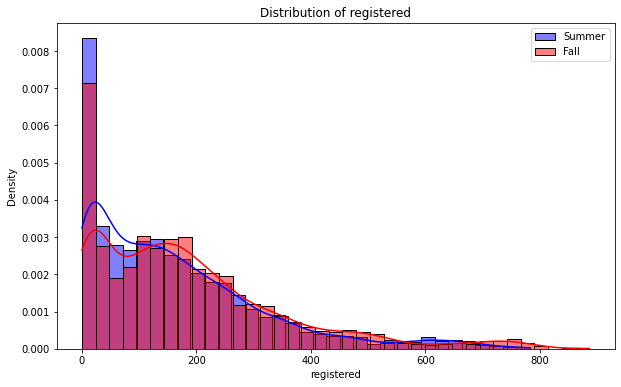

Feature: registered, Seasons: Summer vs Fall
KS Statistic: 0.07783733975070403, KS p-value: 3.4947600369150678e-12
PSI: 0.35508473530409573
----------------------------------------------


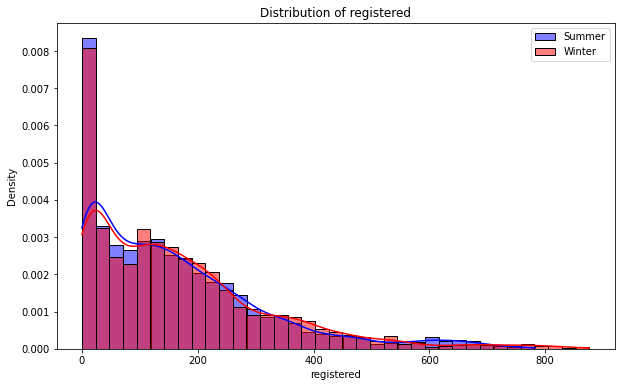

Feature: registered, Seasons: Summer vs Winter
KS Statistic: 0.024399953523489715, KS p-value: 0.14942460453149897
PSI: 0.4092518346286579
----------------------------------------------


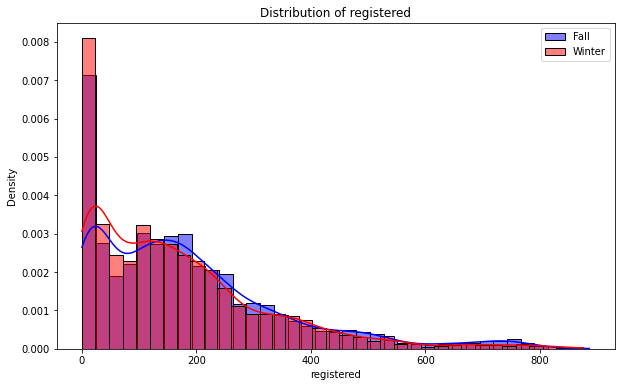

Feature: registered, Seasons: Fall vs Winter
KS Statistic: 0.05885298589294243, KS p-value: 5.201423038947439e-07
PSI: 0.4235314181777671
----------------------------------------------


In [ ]:
def calculate_metrics(train, test, feature):
    ks_stat, ks_pval = ks_2samp(train[feature], test[feature])
    psi = np.mean((np.log(train[feature].value_counts(normalize=True)) - np.log(test[feature].value_counts(normalize=True))) ** 2)
    return ks_stat, ks_pval, psi

def plot_distributions(train, test, feature, label1, label2):
    plt.figure(figsize=(10, 6))
    sns.histplot(train[feature], color='blue', kde=True, stat='density', label=label1)
    sns.histplot(test[feature], color='red', kde=True, stat='density', label=label2)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

season_names = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

features = ['hr', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'registered']

for feature in features:
    for season1, season2 in itertools.combinations(range(1, 5), 2):
        season1_data = hour_data[hour_data['season'] == season1]
        season2_data = hour_data[hour_data['season'] == season2]

        season1_name = season_names[season1]
        season2_name = season_names[season2]

        plot_distributions(season1_data, season2_data, feature, season1_name, season2_name)
        ks_stat, ks_pval, psi = calculate_metrics(season1_data, season2_data, feature)
        print(f'Feature: {feature}, Seasons: {season1_name} vs {season2_name}')
        print(f'KS Statistic: {ks_stat}, KS p-value: {ks_pval}')
        print(f'PSI: {psi}')
        print('----------------------------------------------')

По данным графикам и метрикам можно отследить сходства/различия признаков между сезонами:

- hr - не можем считать распределения различными, во все сезоны распределения проката велосипедов по часам примерно одинаковые.
- weekday - не можем считать распределения различными, во все сезоны распределения проката велосипедов по дням недели примерно одинаковые.
- weathersit - распределения различны между сезонами: Spring vs Fall, Summer vs Fall, Summer vs Winter, Fall vs Winter, это довольно логично, противоречий нет.
- temp - распределения различны между сезонами: Spring vs Winter, Summer vs Fall, Summer vs Winter, это довольно логично, противоречий нет.
- hum - распределения различны во всех случаях.
- windspeed -  распределения различны во всех случаях.
- casual - распределения различны во всех случаях.
- registered - распределения различны во всех случаях, кроме Summer vs Winter. Видимо, число людей, которые зарегистрировались и воспользовались прокатом велосипедов летом и зимой сильно различается.

# Проверка гипотез

Проведем проверку нескольких продуктовых гипотез

In [ ]:
mean_diff = lambda x: np.mean(x)

def ttest(group1, group2):
    t_stat, p_val = stats.ttest_ind(group1, group2)

    print("ttest_statistic:", t_stat)
    print("ttest_P-value:", p_val)

def mannwhitneyu(group1, group2):
    statistic, p_value = stats.mannwhitneyu(group1, group2)

    print("mannwhitneyu_statistic:", statistic)
    print("mannwhitneyu_P-value:", p_value)

def bootstrap(group1, group2):
    print("Difference:", (group1.mean() - group2.mean()))
    bootstrap_diffs = bootstrap_stat_diff(group1, group2, mean_diff)

    conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])

    print("95% Confidence Interval for Difference:", conf_interval)

def bootstrap_stat_diff_multiple_groups(groups, statistic):
    n_groups = len(groups)
    n_samples = [len(group) for group in groups]
    n_total = sum(n_samples)
    all_data = np.concatenate(groups)
    diffs = []
    for _ in range(1000):
        sample = np.random.choice(all_data, size=n_total, replace=True)
        new_groups = [sample[start:start+size] for start, size in zip(np.cumsum([0] + n_samples), n_samples)]
        stats = [statistic(group) for group in new_groups]
        diffs.append(max(stats) - min(stats))
    return np.array(diffs)

def bootstrap_stat_diff(data1, data2, stat_func, num_iterations=10000):
    diffs = []
    for _ in range(num_iterations):
        sample1 = np.random.choice(data1, len(data1), replace=True)
        sample2 = np.random.choice(data2, len(data2), replace=True)
        stat1 = stat_func(sample1)
        stat2 = stat_func(sample2)
        diff = stat1 - stat2
        diffs.append(diff)
    return diffs

### 1) Проведем тест: существует ли различие в количестве прокатов в выходные и будние дни?

- H0: Среднее количество прокатов в будние дни равно среднему количеству прокатов в выходные дни
- H1: Средние количества прокатов в будние дни и выходные дни различаются

In [ ]:
weekend_rentals = hour_data[hour_data['weekday'].isin([0, 6])]
weekday_rentals = hour_data[~hour_data['weekday'].isin([0, 6])]

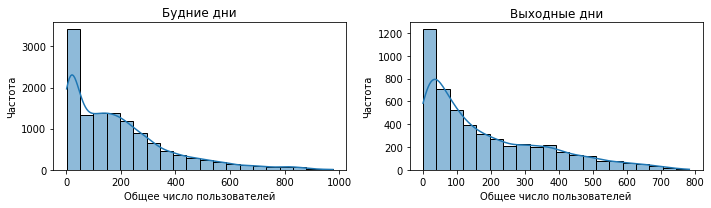

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(weekday_rentals['cnt'], bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Общее число пользователей')
axes[0].set_ylabel('Частота')
axes[0].set_title('Будние дни')

sns.histplot(weekend_rentals['cnt'], bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('Общее число пользователей')
axes[1].set_ylabel('Частота')
axes[1].set_title('Выходные дни')

plt.tight_layout()
plt.show()

Как видно, распределения групп не являются нормальными, тогда проведем непараметрический тест Манна-Уитни для проверки гипотезы.

In [ ]:
mannwhitneyu(weekend_rentals['cnt'], weekday_rentals['cnt'])

mannwhitneyu_statistic: 30575869.5
mannwhitneyu_P-value: 0.15787620333122554


Тест показал значение p-value > 0.05, следовательно, нет оснований отвергнуть нулевую гипотезу - средние количества прокатов в выходные и будние дни одинаковы.

In [ ]:
bootstrap(weekend_rentals['cnt'], weekday_rentals['cnt'])

Difference: -7.886360084202579
95% Confidence Interval for Difference: [-13.6367667  -1.9635835]


### 2) Проведем тест: влияют ли погодные условия на количество прокатов?

- H0: Среднее количество прокатов в хорошую и плохую погоду одинаково.
- H1: Средние количества прокатов в хорошую и плохую погоду различаются.

Разделим данные на дни с хорошей и плохой погодой.

In [ ]:
good_weather_rentals = hour_data[hour_data['weathersit'] == 1]['cnt']
bad_weather_rentals = hour_data[hour_data['weathersit'].isin([2, 3, 4])]['cnt']

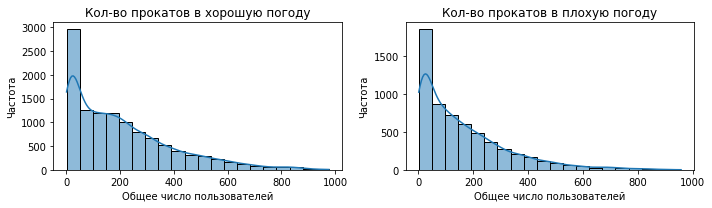

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(good_weather_rentals, bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Общее число пользователей')
axes[0].set_ylabel('Частота')
axes[0].set_title('Кол-во прокатов в хорошую погоду')

sns.histplot(bad_weather_rentals, bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('Общее число пользователей')
axes[1].set_ylabel('Частота')
axes[1].set_title('Кол-во прокатов в плохую погоду')

plt.tight_layout()
plt.show()

Как видно, распределения групп не являются нормальными, тогда проведем непараметрический тест Манна-Уитни для проверки гипотезы.

In [ ]:
mannwhitneyu(good_weather_rentals, bad_weather_rentals)

mannwhitneyu_statistic: 38578422.5
mannwhitneyu_P-value: 3.056125742988085e-47


Тест показал значение p-value < 0.05, следовательно, мы отвергаем нулевую гипотезу о равенстве средних. Вероятно, в хорошую погоду велосипеды в прокат берут большее число людей.

In [ ]:
bootstrap(good_weather_rentals, bad_weather_rentals)

Difference: 44.87832317358749
95% Confidence Interval for Difference: [39.58635398 50.1438705 ]


### 3) Проведем тест: отличается ли среднее количество прокатов, осуществленных зарегистрированными пользователями, от среднего количества прокатов, осуществленных незарегистрированными пользователями?

- H0: Среднее количество прокатов, осуществленных зарегистрированными пользователями, равно среднему количеству прокатов, осуществленных незарегистрированными пользователями.
- H1: Среднее количество прокатов, осуществленных зарегистрированными пользователями, отличается от среднего количества прокатов, осуществленных незарегистрированными пользователями.

In [ ]:
registered_users = hour_data['registered']
casual_users = hour_data['casual']

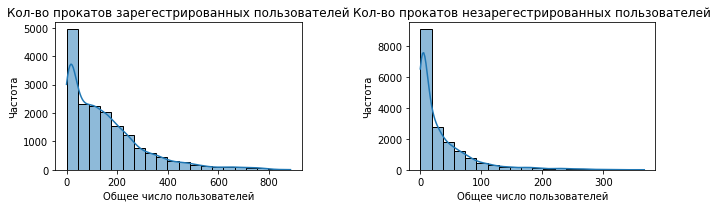

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

sns.histplot(registered_users, bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Общее число пользователей')
axes[0].set_ylabel('Частота')
axes[0].set_title('Кол-во прокатов зарегестрированных пользователей')

sns.histplot(casual_users, bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('Общее число пользователей')
axes[1].set_ylabel('Частота')
axes[1].set_title('Кол-во прокатов незарегестрированных пользователей')

plt.tight_layout()
plt.show()

Как видно, распределения групп не являются нормальными, тогда проведем непараметрический тест Манна-Уитни для проверки гипотезы.

In [ ]:
mannwhitneyu(registered_users, casual_users)

mannwhitneyu_statistic: 241101074.0
mannwhitneyu_P-value: 0.0


Тест показал значение p-value < 0.05, следовательно, мы отвергаем нулевую гипотезу о равенстве средних. Вероятно, число людей, которые проходили регистрацию и пользовались услугами проката, больше, чем незарегистрированных пользоателей.

In [ ]:
bootstrap(registered_users, casual_users)

Difference: 118.11065078543069
95% Confidence Interval for Difference: [115.67295011 120.45158812]


### 4) Проведем тест: если различие в количестве прокатов в разное время года?

- H0: Среднее количество прокатов во всех временах года одинаково.
- H1: Средние количества прокатов в разные времена года различаются.

In [ ]:
seasons_data = {}
for season in range(1, 5):
    seasons_data[season] = hour_data[hour_data['season'] == season]['cnt']

f_stat, p_value = f_oneway(*seasons_data.values())

print("F-статистика:", f_stat)
print("P-значение:", p_value)

F-статистика: 409.1810372630525
P-значение: 7.40107139971279e-257


Тест показал значение p-value < 0.05, следовательно, мы отвергаем нулевую гипотезу о равенстве средних. Средние количества прокатов в разные времена года различаются. Вероятно, весной и летом количество прокатов больше.

In [ ]:
groups = [seasons_data[1], seasons_data[2], seasons_data[3], seasons_data[4]]
bootstrap_diffs = bootstrap_stat_diff_multiple_groups(groups, np.mean)
conf_interval = np.percentile(bootstrap_diffs, [2.5, 97.5])
print("95% Confidence Interval for Difference:", conf_interval)

95% Confidence Interval for Difference: [ 1.42022358 11.42380127]


Все проверенные гипотезы показали вполне логичные результаты.

# Обучение модели линейной регрессии

Для начала - возьмем все признаки, входящие в датасет и обучим модель, которая будет предсказывать значения общего числа пользователей.

In [ ]:
df = copy.deepcopy(hour_data)

X = sm.add_constant(df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp',
            'hum', 'windspeed', 'casual', 'registered']])

model = sm.OLS(df['cnt'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.293e+31
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:48:03   Log-Likelihood:             4.5368e+05
No. Observations:               17379   AIC:                        -9.073e+05
Df Residuals:                   17364   BIC:                        -9.072e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.824e-13   5.58e-14     14.016      0.0

Оценки коэффициентов не являются статистически значимыми, проведем тесты на гетероскедастичность и мультиколлинеарность признаков.

### Проведем тест на мультиколлинеарность

In [ ]:
vif = pd.DataFrame()
vif["Features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Results:")
print(vif)

VIF Results:
      Features        VIF
0        const  43.671117
1       season   3.527410
2           yr   1.094830
3         mnth   3.285116
4           hr   1.262889
5      holiday   1.084497
6      weekday   1.017867
7   workingday   1.404402
8   weathersit   1.283971
9         temp  43.821366
10       atemp  44.069280
11         hum   1.666538
12   windspeed   1.199882
13      casual   2.181243
14  registered   1.786158


- Высокие значения VIF указывают на то, что соответствующий предиктор является мультиколлинеарным с другими предикторами в модели.  
- В данном случае очень высокие значения VIF имеют признаки 'temp' и 'atemp'. Это логично, так как оба указывают на значения температуры, один из них можно убрать из общего числа признаков.

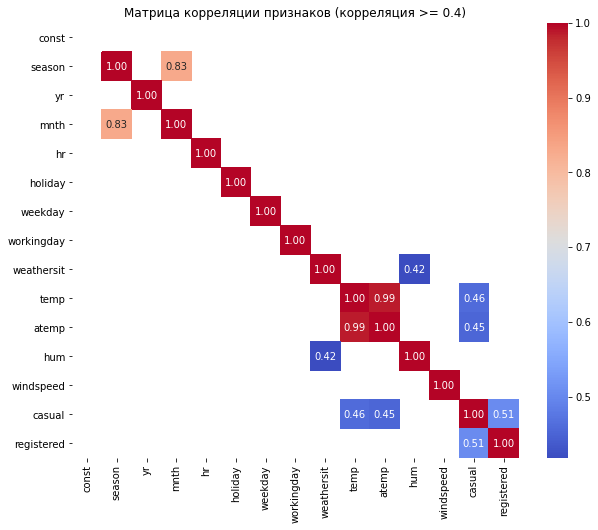

In [ ]:
correlation_matrix = X.corr()

filtered_corr_matrix = correlation_matrix[np.abs(correlation_matrix) >= 0.3]
filtered_corr_matrix[filtered_corr_matrix < 0.4] = np.nan

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Матрица корреляции признаков (корреляция >= 0.4)')
plt.show()

- По корреляционной матрице также можно увидеть, что признаки 'temp' и 'atemp' имеют очень высокую корреляцию.
- Ещё высокую корреляцию имеют признаки 'mnth' и 'season'. Возможно, один из этих признаков также стоит исключить из модели.

In [ ]:
X = sm.add_constant(df[['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'registered', 'casual']])

model = sm.OLS(df['cnt'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.460e+32
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:48:27   Log-Likelihood:             4.7422e+05
No. Observations:               17379   AIC:                        -9.484e+05
Df Residuals:                   17367   BIC:                        -9.483e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.307e-13   1.56e-14     53.122      0.0

После удаления коррелирующих признаков всё ещё остаются коэффициенты, оценки которых не являются статистически значимыми. Проведем тест на гетероскедастичность.

### Проведем тест Гольдфельда-Куандта на гетероскедастичность

In [ ]:
gq_test = het_goldfeldquandt(results.resid, results.model.exog)
print("Goldfeld-Quandt Test Results:")
print("F Statistic:", gq_test[0])
print("p-value:", gq_test[1])

Goldfeld-Quandt Test Results:
F Statistic: 2.7076622481801467
p-value: 0.0


Гипотеза в тесте Гольдфельда-Куандта состоит в том, что ошибка модели гомоскедастична. Данное маленькое p-значение говорит о том, что мы можем отвергнуть нулевую гипотезу в пользу альтернативной, что говорит о наличии гетероскедастичности в данных. Это может быть проблемой для оценки модели, так как оценки коэффициентов могут быть неэффективными и неверными.

Построим QQ-график ошибок модели

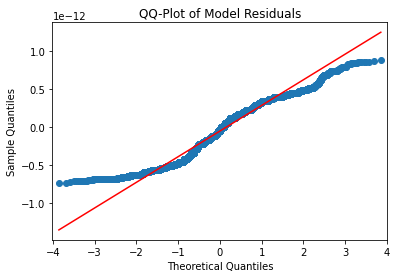

In [ ]:
residuals = results.resid
sm.qqplot(residuals, line='s')
plt.title('QQ-Plot of Model Residuals')
plt.show()

По данному графику также можно отследить гетероскедастичность данных.

Вместо стандартных оценок можно использовать робастные стандартные ошибки. Эти стандартные ошибки корректируются на гетероскедастичность и делают оценки коэффициентов более эффективными.

In [ ]:
X = sm.add_constant(df[['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'registered', 'casual']])

model = sm.OLS(df['cnt'], X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.227e+32
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:49:00   Log-Likelihood:             4.7261e+05
No. Observations:               17379   AIC:                        -9.452e+05
Df Residuals:                   17367   BIC:                        -9.451e+05
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.311e-13   1.76e-14     35.829      0.0

- R-squared: Значение равное 1 указывает на то, что модель идеально подходит под данные, объясняя 100% вариации зависимой переменной.

- Adj.R-squared: Аналогично R-квадрату, он показывает долю вариации зависимой переменной, объясненной моделью.

- F-statistic: оценивает, насколько хорошо модель подходит для предсказания зависимой переменной. Значение очень высокое, что указывает на то, что модель является статистически значимой.

- Prob(F-statistic): Это p-значение для F-статистики. Нулевое значение близкое к нулю указывает на статистическую значимость модели.

- Все оценки коэффициентов на этот раз показали статистически значимые связи между каждым предиктором и зависимой переменной.

- Cond. No.: Это число, называемое числом условия, которое показывает, насколько независимые переменные в модели коррелируют между собой. Получилось очень высокое значение, что может указывать на мультиколлинеарность или другие проблемы.

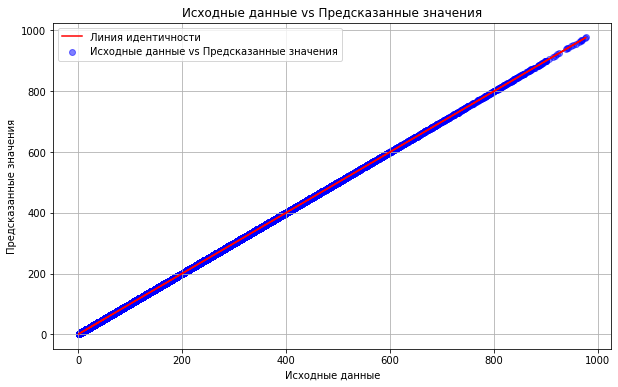

In [ ]:
predicted_values = results.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(df['cnt'], predicted_values, alpha=0.5, color='b', label='Исходные данные vs Предсказанные значения')
plt.plot(df['cnt'], df['cnt'], color='r', label='Линия идентичности')
plt.title('Исходные данные vs Предсказанные значения')
plt.xlabel('Исходные данные')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.grid(True)
plt.show()

Обученная модель очень точно описывает целевую переменную.

Но если обратить внимание на оценки коэффициентов, то почти все они близки к нулю, кроме 'registered' и 'casual'.

In [ ]:
X = sm.add_constant(df[['registered', 'casual']])

model = sm.OLS(df['cnt'], X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.224e+34
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:49:14   Log-Likelihood:             4.9338e+05
No. Observations:               17379   AIC:                        -9.867e+05
Df Residuals:                   17376   BIC:                        -9.867e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.066e-14   1.24e-15     64.857      0.0

Эти два признака очень хорошо описывают зависимую переменную, что вполне логично, так как также являются описанием общего числа пользователей.

Посмотрим, что будет, если исключить оба этих признака и остальные коррелирующие признаки. Насколько хорошо другие признаки смогут описать целевую переменную.

In [ ]:
X = sm.add_constant(df[['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
            'hum', 'windspeed']])

model = sm.OLS(df['cnt'], X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     1040.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:49:40   Log-Likelihood:            -1.1078e+05
No. Observations:               17379   AIC:                         2.216e+05
Df Residuals:                   17368   BIC:                         2.217e+05
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -15.3094      5.989     -2.556      0.0

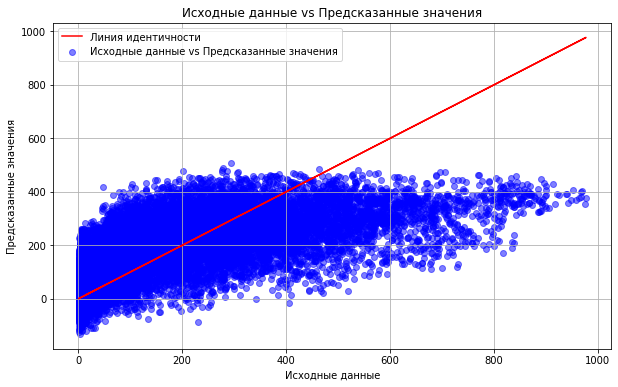

In [ ]:
predicted_values = results.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(df['cnt'], predicted_values, alpha=0.5, color='b', label='Исходные данные vs Предсказанные значения')
plt.plot(df['cnt'], df['cnt'], color='r', label='Линия идентичности')
plt.title('Исходные данные vs Предсказанные значения')
plt.xlabel('Исходные данные')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.grid(True)
plt.show()

Признаки очень плохо описывают целевую переменную.

Попробуем добавить переменную 'registered'

In [ ]:
X = sm.add_constant(df[['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp',
            'hum', 'registered']])

model = sm.OLS(df['cnt'], X)
results = model.fit(cov_type='HC3')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 4.027e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:49:47   Log-Likelihood:                -85637.
No. Observations:               17379   AIC:                         1.713e+05
Df Residuals:                   17368   BIC:                         1.714e+05
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0150      1.336     18.721      0.0

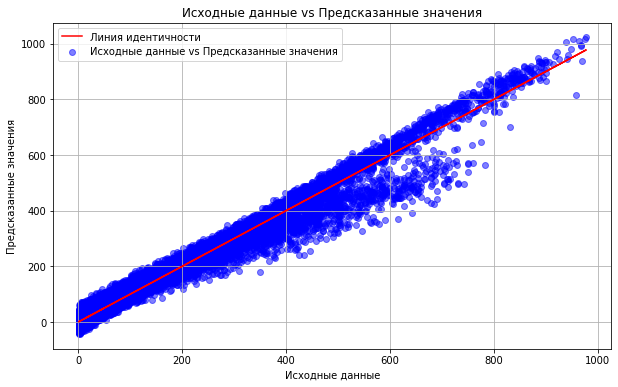

In [ ]:
predicted_values = results.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(df['cnt'], predicted_values, alpha=0.5, color='b', label='Исходные данные vs Предсказанные значения')
plt.plot(df['cnt'], df['cnt'], color='r', label='Линия идентичности')
plt.title('Исходные данные vs Предсказанные значения')
plt.xlabel('Исходные данные')
plt.ylabel('Предсказанные значения')
plt.legend()
plt.grid(True)
plt.show()

- Таким образом, если мы имеем информацию о количестве зарегистрированных пользователей, то обученная модель дает довольно точные результаты, это связано с высокой корреляцией между данным признаком и целевой переменной.
- Однако если мы ничего не знаем о количестве зарегистрированных пользователей, то по остальным признакам довольно сложно предсказать общее число пользователей.

Возможно, в модели, которая не использует информацию о зарегестрированных/незарегестрированных пользователях, недостаточно информативных признаков, чтобы хорошо описать целевую переменную, недостаточный объем данных или стоит рассмотреть возможность использования других моделей машинного обучения, таких как деревья решений, случайные леса.

# Заключение

В рамках данного проекта:
- был проведен анализ датасета на предмет распределений признаков между сезонами;
- сформулированы и протестированы несколько интересных продуктовых гипотез;
- основываясь на предоставленной информации о погоде и сезонах, был проведен анализ признаков, протестированы несколько спецификаций моделей линейной регрессии, выявлена лучшая для различных случаев.